In [2]:
# Install missing dependencies
!pip install -q diffusers transformers accelerate peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 wh

In [3]:
import os
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import display, Image as IPyImage
from PIL import Image


def load_trained_model(base_model_path, lora_model_path, device):
    """Load a previously trained LoRA model for image generation."""
    # Print loading status
    print(f"Loading LoRA weights from: {lora_model_path}")
    
    # Load base model
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_path, 
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    # Load LoRA weights
    from peft import PeftModel
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_model_path)
    
    # Merge weights for faster inference
    print("Merging LoRA weights with base model...")
    pipe.unet = pipe.unet.merge_and_unload()
    
    # Use faster scheduler
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    
    # Move to GPU
    pipe = pipe.to(device)
    
    return pipe


def generate_images(
    pipe,
    prompt,
    output_dir="generated_images",
    negative_prompt="lowres, bad anatomy, bad hands, cropped, worst quality, low quality, blurry",
    num_images=1,
    height=512,
    width=512,
    guidance_scale=7.5,
    num_steps=50,
    seed=None,
    display_images=True
):
    """Generate images from a user prompt using the trained LoRA model."""
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Set seed for reproducibility if provided
    if seed is not None:
        torch.manual_seed(seed)
        print(f"Using seed: {seed}")
    
    print(f"Generating {num_images} image(s) for prompt: \"{prompt}\"")
    print(f"Image size: {width}x{height}, Steps: {num_steps}, Guidance scale: {guidance_scale}")
    
    generated_images = []
    
    # Generate images
    for i in range(num_images):
        # Generate image
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            height=height,
            width=width,
            num_inference_steps=num_steps,
            guidance_scale=guidance_scale
        ).images[0]
        
        # Save image
        filename = f"{output_dir}/image_{i+1}.png"
        image.save(filename)
        print(f"Saved image to {filename}")
        
        # Add to list for display
        generated_images.append(image)
    
    # Display images in notebook if requested
    if display_images:
        for img in generated_images:
            display(img)
    
    print(f"Successfully generated {num_images} image(s)!")
    return generated_images


def kaggle_interactive():
    """Interactive function for Kaggle notebook."""
    # Default settings
    base_model_path = "CompVis/stable-diffusion-v1-4"
    lora_model_path = "/kaggle/input/naruto_blip_epoch10_v2/other/default/1/epoch-9"
    output_dir = "/kaggle/working/generated_images"
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load model
    pipe = load_trained_model(base_model_path, lora_model_path, device)
    
    # Define a function that can be called interactively
    def generate(
        prompt, 
        negative_prompt="lowres, bad anatomy, bad hands, cropped, worst quality, low quality, blurry",
        num_images=1, 
        height=512, 
        width=512, 
        guidance_scale=7.5, 
        steps=50, 
        seed=None
    ):
        """Generate images from a prompt."""
        # Create subdirectory based on prompt
        subfolder = os.path.join(output_dir, prompt.replace(" ", "_")[:30])
        
        return generate_images(
            pipe=pipe,
            prompt=prompt,
            output_dir=subfolder,
            negative_prompt=negative_prompt,
            num_images=num_images,
            height=height,
            width=width,
            guidance_scale=guidance_scale,
            num_steps=steps,
            seed=seed
        )
    
    # Return the function for use in the notebook
    return generate

2025-04-21 22:23:37.737776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745274218.164834      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745274218.312294      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
generate = kaggle_interactive()

Using device: cuda
Loading LoRA weights from: /kaggle/input/naruto_blip_epoch10_v2/other/default/1/epoch-9


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Merging LoRA weights with base model...


Generating 2 image(s) for prompt: "Naruto using rasengan against Pain, detailed anime style"
Image size: 512x512, Steps: 75, Guidance scale: 8.0


  0%|          | 0/75 [00:00<?, ?it/s]

Saved image to /kaggle/working/generated_images/Naruto_using_rasengan_against_/image_1.png


  0%|          | 0/75 [00:00<?, ?it/s]

Saved image to /kaggle/working/generated_images/Naruto_using_rasengan_against_/image_2.png


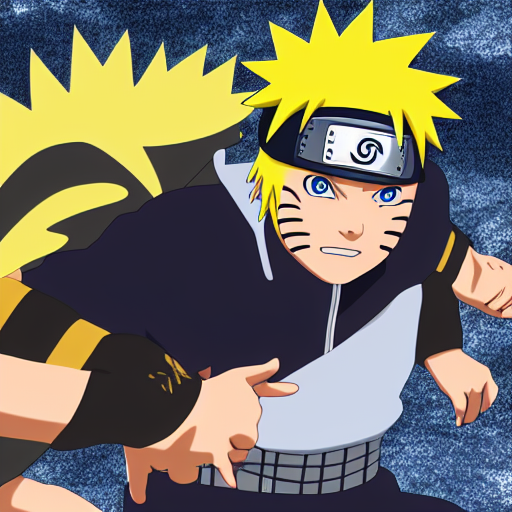

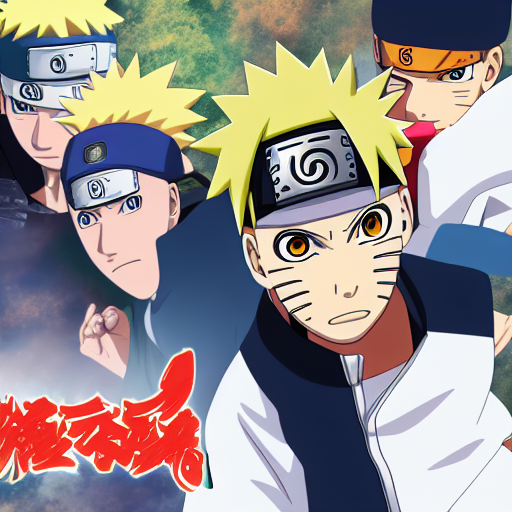

Successfully generated 2 image(s)!


[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [6]:
generate(
    prompt="Naruto using rasengan against Pain, detailed anime style",
    num_images=2, 
    guidance_scale=8.0,
    steps=75
)

Generating 2 image(s) for prompt: "Sasuke with Sharingan and Susanoo, high quality anime art"
Image size: 512x512, Steps: 75, Guidance scale: 8.0


  0%|          | 0/75 [00:00<?, ?it/s]

Saved image to /kaggle/working/generated_images/Sasuke_with_Sharingan_and_Susa/image_1.png


  0%|          | 0/75 [00:00<?, ?it/s]

Saved image to /kaggle/working/generated_images/Sasuke_with_Sharingan_and_Susa/image_2.png


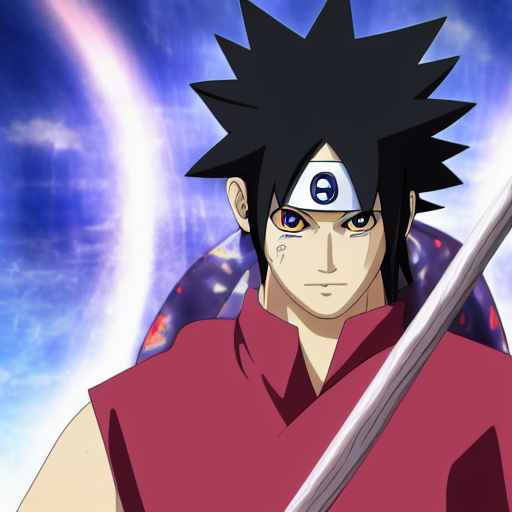

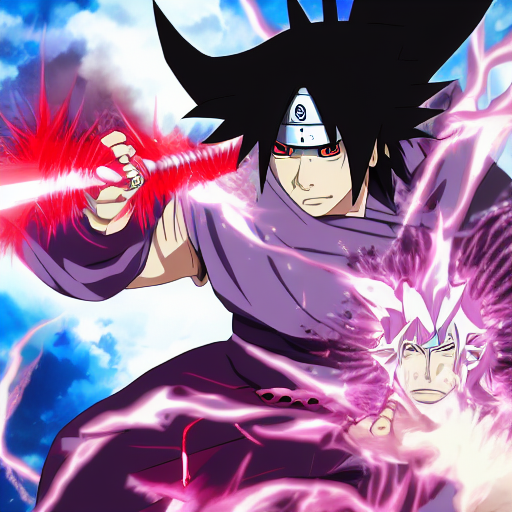

Successfully generated 2 image(s)!


[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [8]:

generate(
    prompt="Sasuke with Sharingan and Susanoo, high quality anime art", 
    num_images=2, 
    guidance_scale=8.0,
    steps=75
)

Generating 2 image(s) for prompt: "Naruto with rasengan, high quality anime art"
Image size: 512x512, Steps: 75, Guidance scale: 8.0


  0%|          | 0/75 [00:00<?, ?it/s]

Saved image to /kaggle/working/generated_images/Naruto_with_rasengan,_high_qua/image_1.png


  0%|          | 0/75 [00:00<?, ?it/s]

Saved image to /kaggle/working/generated_images/Naruto_with_rasengan,_high_qua/image_2.png


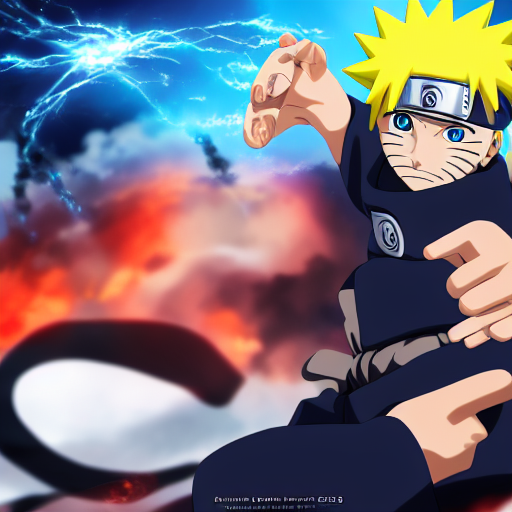

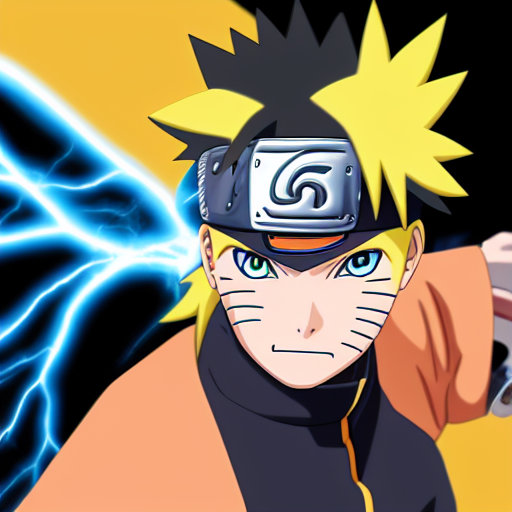

Successfully generated 2 image(s)!


[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [14]:

generate(
    prompt="Naruto with rasengan, high quality anime art", 
    num_images=2, 
    guidance_scale=8.0,
    steps=75
)